In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import wget

In [2]:
# URL ='https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip'
# file_name = wget.download(URL)

In [3]:
# import zipfile
# with zipfile.ZipFile(file_name, 'r') as zip_ref:
#     zip_ref.extractall()

In [4]:
# Path to the data directory
data_dir = Path("./picked_preprocessed/")
data_dir2 = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
images += sorted(list(map(str, list(data_dir2.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50 

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  6040
Number of labels found:  6040
Number of unique characters:  62
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # subtract all pixel by the min value
    img = tf.subtract(img, tf.math.reduce_min(img))
    # img = tf.multiply( tf.divide(img,tf.math.reduce_max(img)), 255 )
    
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # img = tf.image.resize(img, [img_width, img_width])

    # #crop the height to 100
    # start = int((img_width-img_height)/2)
    # end = start + img_height

    # img = img[start:end, 0:200]

    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0
min 0.0


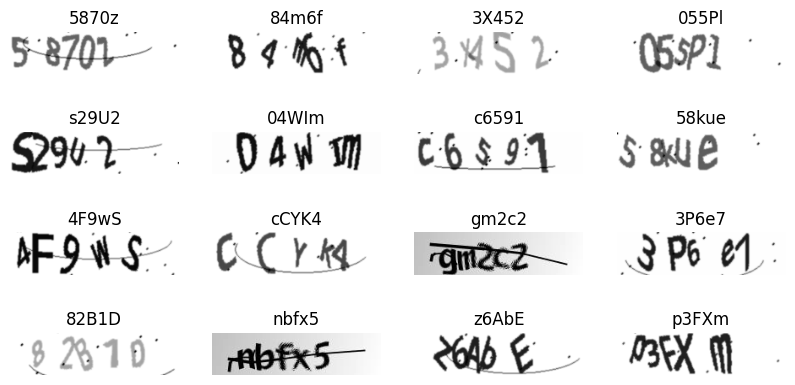

In [7]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        print("min",np.min( images[i]) )
        # print("max",np.max( images[i]) )
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [13]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


#import Sequential model and layers
from tensorflow.keras.models import Sequential

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    #Alexnet feature extraction
    # x = layers.Conv2D(filters=32, kernel_size=(11,11), strides=(1,1), padding='same')(input_img)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation('relu')(x)
    # x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    # x = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation('relu')(x)
    # x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    # x = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation('relu')(x)

    # x = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation('relu')(x)

    # x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation('relu')(x)
    # x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    # # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    #Third conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    # new_shape = ((img_width // 2), (img_height // 2) * 32) # 1 conv layers
    # new_shape = ((img_width // 4), (img_height // 4) * 64) # 2 conv layers
    new_shape = ((img_width // 8), (img_height // 8) * 128) # 3 conv layers
    # new_shape = (25,7*64) #alexnet
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    # x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    # x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    # x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    #best
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.25))(x)

    #worst
    # x = layers.GRU(128, return_sequences=True, dropout=0.25)(x)
    # x = layers.GRU(64, return_sequences=True, dropout=0.25)(x)

    # x = layers.Bidirectional(layers.SimpleRNN(128, return_sequences=True, dropout=0.25))(x)
    # x = layers.Bidirectional(layers.SimpleRNN(64, return_sequences=True, dropout=0.25))(x)


    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 200, 50, 32)  3904        ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 50, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [9]:
# epochs =  50
# early_stopping_patience = 10
# # Add early stopping
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
# )

# # Train the model
# history = model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=epochs,
#     callbacks=[early_stopping],
# )

In [10]:
# #draw loss
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# #x title
# plt.xlabel('Epoch')
# #y title
# plt.ylabel('CTC Loss')
# plt.legend()
# plt.show()

In [11]:
# layer_name = 'dense2'
# new_model = tf.keras.Model(inputs = model.input, outputs= model.get_layer(layer_name).output)
# new_model.save('captcha_images.h5')

In [12]:
trained_model = tf.keras.models.load_model('captcha_images.h5')
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 200, 50, 32)  3904        ['image[0][0]']                  
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 200, 50, 32)  128        ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                              

loop
1/1 [==============================] - 18s 18s/step
loop
1/1 [==============================] - 0s 238ms/step
loop
1/1 [==============================] - 0s 296ms/step
loop
1/1 [==============================] - 0s 304ms/step
loop
1/1 [==============================] - 0s 216ms/step
loop
1/1 [==============================] - 0s 223ms/step
loop
1/1 [==============================] - 0s 352ms/step
loop
1/1 [==============================] - 0s 235ms/step
loop
1/1 [==============================] - 0s 367ms/step
loop
1/1 [==============================] - 0s 241ms/step
loop
1/1 [==============================] - 0s 341ms/step
loop
1/1 [==============================] - 0s 335ms/step
loop
1/1 [==============================] - 0s 217ms/step
loop
1/1 [==============================] - 0s 179ms/step
loop
1/1 [==============================] - 0s 195ms/step
loop
1/1 [==============================] - 0s 336ms/step
loop
1/1 [==============================] - 0s 177ms/step
loop
1/1 [=====

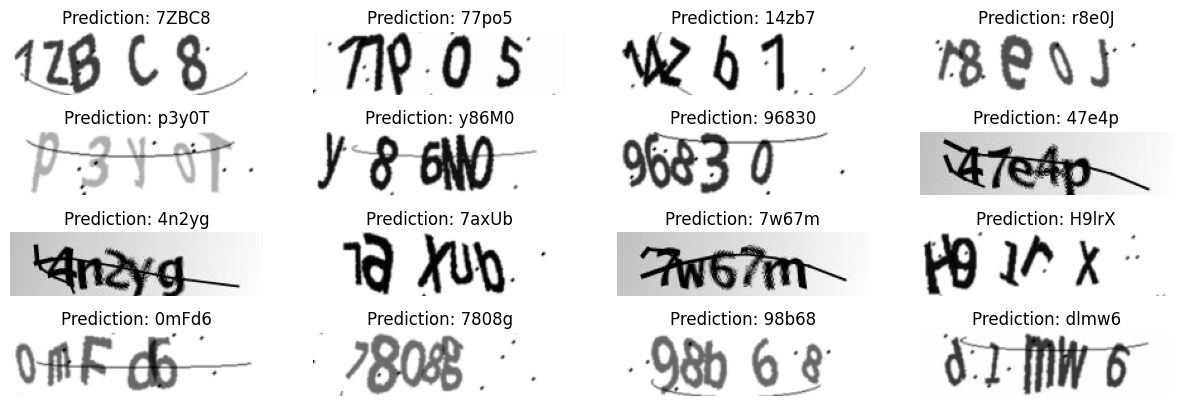

In [13]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
all_pred_texts = []
orig_texts = []
import time
total_time = 0
total_batches = 0

first = True
for batch in validation_dataset.take(-1):
    print('loop')
    batch_images = batch["image"]
    batch_labels = batch["label"]

    start_time = time.time()
    preds = trained_model.predict(batch)
    pred_texts = decode_batch_predictions(preds)
    total_time += time.time() - start_time
    total_batches += 1
    all_pred_texts.extend(pred_texts)

    labels = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        labels.append(label)
        orig_texts.append(label)


    if first:
        _, ax = plt.subplots(4, 4, figsize=(15, 5))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")

        first = False
plt.show()

# Metrics and compare

In [14]:
def trueWord_Metric(y_true, y_pred):
  bool_arr = [y_true[i] == y_pred[i] for i in range(len(y_true))]
  return sum(bool_arr)/len(y_true)

def trueChar_Metric(y_true, y_pred):
  total_charCheck = 0
  num_true = 0
  
  for i in range(len(y_true)):
    if (len(y_true[i]) > len(y_pred[i])):
      total_charCheck += len(y_true[i])
    else:
      total_charCheck += len(y_pred[i])

    bool_arr = [val_true == val_pred for val_true, val_pred in zip(y_true[i], y_pred[i])]
    num_true += sum(bool_arr)
  return num_true/total_charCheck
def optimal_string_alignment_distance(s1, s2):
    # Create a table to store the results of subproblems
    dp = [[0 for j in range(len(s2)+1)] for i in range(len(s1)+1)]
     
    # Initialize the table
    for i in range(len(s1)+1):
        dp[i][0] = i
    for j in range(len(s2)+1):
        dp[0][j] = j
 
    # Populate the table using dynamic programming
    for i in range(1, len(s1)+1):
        for j in range(1, len(s2)+1):
            if s1[i-1] == s2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
 
    # Return the edit distance
    return dp[len(s1)][len(s2)]

def Damerau_Levenshtein_Metric(y_true, y_pred):
  distance = [optimal_string_alignment_distance(y_true[i], y_pred[i]) for i in range(len(y_true))]
  return sum(distance)

In [15]:
y_pred = all_pred_texts
y_true = orig_texts
print(trueWord_Metric(y_true, y_pred))
print(Damerau_Levenshtein_Metric(y_true, y_pred))

time_per_batch = total_time/total_batches
time_per_image = time_per_batch/batch_size
print('time_per_batch', time_per_batch)
print('time_per_image', time_per_image)

0.9668874172185431
28
time_per_batch 0.9435448960254067
time_per_image 0.05897155600158792


# Trash Play Around

In [16]:
batch

{'image': <tf.Tensor: shape=(12, 200, 50, 1), dtype=float32, numpy=
 array([[[[0.48627454],
          [0.48627454],
          [0.48627454],
          ...,
          [0.48627454],
          [0.48627454],
          [0.48627454]],
 
         [[0.48627454],
          [0.48627454],
          [0.48627454],
          ...,
          [0.48627454],
          [0.48627454],
          [0.48627454]],
 
         [[0.48627454],
          [0.48627454],
          [0.48627454],
          ...,
          [0.48627454],
          [0.48627454],
          [0.48627454]],
 
         ...,
 
         [[0.48627454],
          [0.48627454],
          [0.48627454],
          ...,
          [0.48627454],
          [0.48627454],
          [0.48627454]],
 
         [[0.48627454],
          [0.48627454],
          [0.48627454],
          ...,
          [0.48627454],
          [0.48627454],
          [0.48627454]],
 
         [[0.48627454],
          [0.48627454],
          [0.48627454],
          ...,
          [0.486274

In [17]:
def nth_layer_output(model, n ,img):
    temp_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n].output)
    print(temp_model.output)
    output = temp_model.predict(batch)
    return output

batch['image'].shape
batch['label'][0]



<tf.Tensor: shape=(5,), dtype=int64, numpy=array([35, 50, 49, 54, 32], dtype=int64)>

In [18]:
layer_output = nth_layer_output(trained_model, 11, batch)

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 13, 128), dtype=tf.float32, name=None), name='activation_7/Relu:0', description="created by layer 'activation_7'")
1/1 [==============================] - 0s 223ms/step


In [19]:
print(layer_output[0])
#print max index of each array in layer_output[0]
print(np.argmax(layer_output[0], axis=1))

[[[0.8286097  0.7320665  0.         ... 0.         0.         0.        ]
  [0.10894409 0.67747885 0.         ... 0.         0.         0.        ]
  [0.         0.66087276 0.         ... 0.         0.         0.        ]
  ...
  [0.         0.80175054 0.         ... 0.         0.         0.        ]
  [0.         0.2734712  0.         ... 0.         0.         0.        ]
  [0.         0.22780067 0.         ... 0.         0.         0.        ]]

 [[0.77711433 0.66119146 0.         ... 0.15522552 0.30010644 0.1425924 ]
  [0.2738649  0.42187065 0.         ... 0.40156737 0.         0.        ]
  [0.         0.4499371  0.         ... 0.3117081  0.         0.29184014]
  ...
  [0.         0.5329005  0.         ... 0.         0.         0.8222802 ]
  [0.         0.10781233 0.         ... 0.04256402 0.         0.5767726 ]
  [0.         0.03424176 0.         ... 0.         0.13588236 0.40351737]]

 [[0.50112236 0.56425816 0.         ... 0.37009418 0.66344357 0.11508732]
  [0.10160984 0.195930

In [20]:
print(layer_output.shape)
print(layer_output[0][0].shape)
print(layer_output[0][0])
pred = layer_output
input_len = np.ones(pred.shape[0]) * pred.shape[1]
print(input_len)
# Use greedy search. For complex tasks, you can use beam search
results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
    :, :max_length
]
# Iterate over the results and get back the text
for res in results:
    print(res.numpy())
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    print(res)

(12, 50, 13, 128)
(13, 128)
[[0.8286097  0.7320665  0.         ... 0.         0.         0.        ]
 [0.10894409 0.67747885 0.         ... 0.         0.         0.        ]
 [0.         0.66087276 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.80175054 0.         ... 0.         0.         0.        ]
 [0.         0.2734712  0.         ... 0.         0.         0.        ]
 [0.         0.22780067 0.         ... 0.         0.         0.        ]]
[50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]


InvalidArgumentError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:GPU:0}} transpose expects a vector of size 4. But input(1) is a vector of size 3 [Op:Transpose]